# Synthetic Discussions analysis

## Preprocessing

In [1]:
%cd ..

/home/dimits/Documents/research/llm_moderation/synthetic_moderation_experiments


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tasks import preprocessing


CONVERSATION_DIR = "data/discussions_output"
ANNOTATION_DIR = "data/annotations_output" 

### Importing the synthetic conversations

In [3]:
conv_df = preprocessing.import_and_format_conversations(CONVERSATION_DIR)
conv_df

,id,timestamp,users,user_types,moderator,moderator_type,user_prompts,moderator_prompt,ctx_length,conv_variant,...,message,user_prompt,moderator_exists,age,gender,profession,education,is_heterosexual,intent,traits
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User DarkShadow333 posted:\n> I'm so sick of t...,Model: LlamaModel. Prompt: You are DarkShadow3...,True,29.0,Man,employed,High School,False,Troll,"[intent, with, provocative, impulsive, rebelli..."
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User moderator posted:\n@DarkShadow333: I unde...,Model: LlamaModel. Prompt: You are moderator .,True,NaN,None,employed,None,True,None,"[moderator, are]"
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User TechGuru88 posted:\nI completely agree wi...,Model: LlamaModel. Prompt: You are TechGuru88 ...,True,35.0,Man,employed,Masters,True,Helpful,"[intent, curious, innovative, with, methodical..."
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User moderator posted:\n@DarkShadow333: I unde...,Model: LlamaModel. Prompt: You are moderator .,True,NaN,None,employed,None,True,None,"[moderator, are]"
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User WiseOwl71 posted:\nI must respectfully di...,Model: LlamaModel. Prompt: You are WiseOwl71 7...,True,71.0,Woman,employed,None,True,Helpful,"[calm, intent, thoughtful, with, patient, and,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl71, QueenOfChaos, TechG...","[str, str, str, str, str]",moderator,LLMUser,"[You are GoldenYears66 66 years old, Heterosex...","You are moderator just, strict, understanding....",2,collective_constitution,...,"@QueenOfChaos, I understand that this is a sen...","You are moderator just, strict, understanding.",True,NaN,None,employed,None,True,None,"[just, strict, understanding, moderator, are]"
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl71, QueenOfChaos, TechG...","[str, str, str, str, str]",moderator,LLMUser,"[You are GoldenYears66 66 years old, Heterosex...","You are moderator just, strict, understanding....",2,collective_constitution,...,"@QueenOfChaos, you're so right! I'm sick and t...","You are DarkShadow333 29 years old, Homosexual...",True,29.0,Man,employed,High School,False,None,"[to, from, violate, with, users, impulsive, an..."
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl71, QueenOfChaos, TechG...","[str, str, str, str, str]",moderator,LLMUser,"[You are GoldenYears66 66 years old, Heterosex...","You are moderator just, strict, understanding....",2,collective_constitution,...,,"You are moderator just, strict, understanding.",True,NaN,None,employed,None,True,None,"[just, strict, understanding, moderator, are]"
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl71, QueenOfChaos, TechG...","[

In [4]:
conv_df = conv_df.rename(
    {
        "age": "user_age",
        "ethnicity": "user_ethnicity",
        "is_heterosexual": "user_is_heterosexual",
        "profession": "user_profession",
        "gender": "user_gender",
        "education": "user_education",
        "intent": "user_intent"
    },
    axis=1,
)
conv_df

,id,timestamp,users,user_types,moderator,moderator_type,user_prompts,moderator_prompt,ctx_length,conv_variant,...,message,user_prompt,moderator_exists,user_age,user_gender,user_profession,user_education,user_is_heterosexual,user_intent,traits
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User DarkShadow333 posted:\n> I'm so sick of t...,Model: LlamaModel. Prompt: You are DarkShadow3...,True,29.0,Man,employed,High School,False,Troll,"[intent, with, provocative, impulsive, rebelli..."
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User moderator posted:\n@DarkShadow333: I unde...,Model: LlamaModel. Prompt: You are moderator .,True,NaN,None,employed,None,True,None,"[moderator, are]"
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User TechGuru88 posted:\nI completely agree wi...,Model: LlamaModel. Prompt: You are TechGuru88 ...,True,35.0,Man,employed,Masters,True,Helpful,"[intent, curious, innovative, with, methodical..."
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User moderator posted:\n@DarkShadow333: I unde...,Model: LlamaModel. Prompt: You are moderator .,True,NaN,None,employed,None,True,None,"[moderator, are]"
0,4a2d5eda-2a24-4e55-afad-c000373889ff,24-10-17-11-55,"[QueenOfChaos, WiseOwl71, TechGuru88, doing_my...","[str, str, str, str, str]",moderator,LLMUser,[Model: LlamaModel. Prompt: You are QueenOfCha...,Model: LlamaModel. Prompt: You are moderator ....,2,old,...,User WiseOwl71 posted:\nI must respectfully di...,Model: LlamaModel. Prompt: You are WiseOwl71 7...,True,71.0,Woman,employed,None,True,Helpful,"[calm, intent, thoughtful, with, patient, and,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl71, QueenOfChaos, TechG...","[str, str, str, str, str]",moderator,LLMUser,"[You are GoldenYears66 66 years old, Heterosex...","You are moderator just, strict, understanding....",2,collective_constitution,...,"@QueenOfChaos, I understand that this is a sen...","You are moderator just, strict, understanding.",True,NaN,None,employed,None,True,None,"[just, strict, understanding, moderator, are]"
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl71, QueenOfChaos, TechG...","[str, str, str, str, str]",moderator,LLMUser,"[You are GoldenYears66 66 years old, Heterosex...","You are moderator just, strict, understanding....",2,collective_constitution,...,"@QueenOfChaos, you're so right! I'm sick and t...","You are DarkShadow333 29 years old, Homosexual...",True,29.0,Man,employed,High School,False,None,"[to, from, violate, with, users, impulsive, an..."
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl71, QueenOfChaos, TechG...","[str, str, str, str, str]",moderator,LLMUser,"[You are GoldenYears66 66 years old, Heterosex...","You are moderator just, strict, understanding....",2,collective_constitution,...,,"You are moderator just, strict, understanding.",True,NaN,None,employed,None,True,None,"[just, strict, understanding, moderator, are]"
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,24-11-15-13-07,"[GoldenYears66, WiseOwl

In [5]:
conv_df = conv_df[
    [
        "id",
        "user",
        "moderator_exists",
        "message",
        "user_age",
        "user_is_heterosexual",
        "user_profession",
        "user_gender",
        "user_intent"
    ]
]
conv_df

,id,user,moderator_exists,message,user_age,user_is_heterosexual,user_profession,user_gender,user_intent
0,4a2d5eda-2a24-4e55-afad-c000373889ff,DarkShadow333,True,User DarkShadow333 posted:\n> I'm so sick of t...,29.0,False,employed,Man,Troll
0,4a2d5eda-2a24-4e55-afad-c000373889ff,moderator,True,User moderator posted:\n@DarkShadow333: I unde...,NaN,True,employed,None,None
0,4a2d5eda-2a24-4e55-afad-c000373889ff,TechGuru88,True,User TechGuru88 posted:\nI completely agree wi...,35.0,True,employed,Man,Helpful
0,4a2d5eda-2a24-4e55-afad-c000373889ff,moderator,True,User moderator posted:\n@DarkShadow333: I unde...,NaN,True,employed,None,None
0,4a2d5eda-2a24-4e55-afad-c000373889ff,WiseOwl71,True,User WiseOwl71 posted:\nI must respectfully di...,71.0,True,employed,Woman,Helpful
...,...,...,...,...,...,...,...,...,...
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,moderator,True,"@QueenOfChaos, I understand that this is a sen...",NaN,True,employed,None,None
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,DarkShadow333,True,"@QueenOfChaos, you're so right! I'm sick and t...",29.0,False,employed,Man,None
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,moderator,True,,NaN,True,employed,None,None
0,89ade850-1148-4a7a-a2ea-4b0fad9fc54d,QueenOfChaos,True,I'm glad someone finally spoke up against thes...,32.0,True,unemployed,Woman,None


### Importing the synthetic annotations

In [8]:
annot_df = preprocessing.import_annotations(ANNOTATION_DIR, round=True, sentinel_value=-1)
annot_df = annot_df[annot_df.toxicity != -1]
annot_df = annot_df[["conv_id", "annotator_prompt", "message", "toxicity"]]
annot_df

,conv_id,annotator_prompt,message,toxicity
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,"You are 30 years old, Heterosexual, Asian, So...",I completely agree with @GoldenYears66 that it...,1
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,"You are 30 years old, Heterosexual, Asian, So...","I completely agree with you, @WiseOwl71. As a ...",1
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,"You are 30 years old, Heterosexual, Asian, So...","I couldn't agree more with your sentiments, @G...",1
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,"You are 30 years old, Heterosexual, Asian, So...","I'm not sure what's more disturbing, the fact ...",5
0,c7134932-480f-43b8-85be-abdeea9a3135,"You are 30 years old, Bisexual, African Ameri...","""Are you kidding me? This is a free country, r...",4
...,...,...,...,...
0,75651ec0-7227-438f-963c-3dd0739d6377,"You are 70 years old, Heterosexual, African A...","User WiseOwl71 posted:\n**Comment:** ""I unders...",4
0,75651ec0-7227-438f-963c-3dd0739d6377,"You are 70 years old, Heterosexual, African A...","User doing_my_best24 posted:\n**Comment:** ""I ...",4
0,75651ec0-7227-438f-963c-3dd0739d6377,"You are 70 years old, Heterosexual, African A...","User GoldenYears66 posted:\n**Comment:** ""I'm ...",4
0,75651ec0-7227-438f-963c-3dd0739d6377,"You are 70 years old, Heterosexual, African A...","User QueenOfChaos posted:\n**Comment:** ""Oh, l...",4


In [9]:
demographics_df = (
    annot_df["annotator_prompt"].apply(extract_sdb_attributes).apply(pd.Series)
)
annot_df = pd.concat(
    [annot_df.drop(columns=["annotator_prompt"]), demographics_df], axis=1
)
annot_df = annot_df.rename(
    {
        "age": "annotator_age",
        "ethnicity": "annotator_ethnicity",
        "is_heterosexual": "annotator_is_heterosexual",
        "profession": "annotator_profession",
        "gender": "annotator_gender",
        "education": "annotator_education",
    },
    axis=1,
)
annot_df = annot_df[
    [
        "conv_id",
        "message",
        "toxicity",
        "annotator_age",
        "annotator_is_heterosexual",
        "annotator_profession",
        "annotator_gender",
    ]
]
annot_df

,conv_id,message,toxicity,annotator_age,annotator_is_heterosexual,annotator_profession,annotator_gender
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,I completely agree with @GoldenYears66 that it...,1,30,True,employed,Man
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,"I completely agree with you, @WiseOwl71. As a ...",1,30,True,employed,Man
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,"I couldn't agree more with your sentiments, @G...",1,30,True,employed,Man
0,8bf86b41-6fce-4838-bbc9-24fba2b39e62,"I'm not sure what's more disturbing, the fact ...",5,30,True,employed,Man
0,c7134932-480f-43b8-85be-abdeea9a3135,"""Are you kidding me? This is a free country, r...",4,30,False,employed,Woman
...,...,...,...,...,...,...,...
0,75651ec0-7227-438f-963c-3dd0739d6377,"User WiseOwl71 posted:\n**Comment:** ""I unders...",4,70,True,employed,Man
0,75651ec0-7227-438f-963c-3dd0739d6377,"User doing_my_best24 posted:\n**Comment:** ""I ...",4,70,True,employed,Man
0,75651ec0-7227-438f-963c-3dd0739d6377,"User GoldenYears66 posted:\n**Comment:** ""I'm ...",4,70,True,employed,Man
0,75651ec0-7227-438f-963c-3dd0739d6377,"User QueenOfChaos posted:\n**Comment:** ""Oh, l...",4,70,True,employed,Man


### Creating a unified dataset

In [10]:
combined_df = conv_df.merge(annot_df, left_on=["id", "message"], right_on=["conv_id", "message"])
combined_df.user_age = combined_df.user_age.astype("Int64")
combined_df = combined_df.drop("conv_id", axis=1)
combined_df.head()

,id,user,moderator_exists,message,user_age,user_is_heterosexual,user_profession,user_gender,user_intent,toxicity,annotator_age,annotator_is_heterosexual,annotator_profession,annotator_gender
0,4a2d5eda-2a24-4e55-afad-c000373889ff,DarkShadow333,True,User DarkShadow333 posted:\n> I'm so sick of t...,29,False,employed,Man,Troll,4,30,True,unemployed,Woman
1,4a2d5eda-2a24-4e55-afad-c000373889ff,WiseOwl71,True,User WiseOwl71 posted:\nI must respectfully di...,71,True,employed,Woman,Helpful,1,30,False,employed,Man
2,4a2d5eda-2a24-4e55-afad-c000373889ff,WiseOwl71,True,User WiseOwl71 posted:\nI must respectfully di...,71,True,employed,Woman,Helpful,4,30,True,unemployed,Woman
3,4a2d5eda-2a24-4e55-afad-c000373889ff,WiseOwl71,True,User WiseOwl71 posted:\nI must respectfully di...,71,True,employed,Woman,Helpful,1,70,True,employed,Woman
4,4a2d5eda-2a24-4e55-afad-c000373889ff,QueenOfChaos,True,User QueenOfChaos posted:\nI'm so sick of thes...,32,True,unemployed,Woman,Troll,4,30,False,employed,Man


## Analysis

In [11]:
sns.set(style="whitegrid")

### User intent impact on toxicity

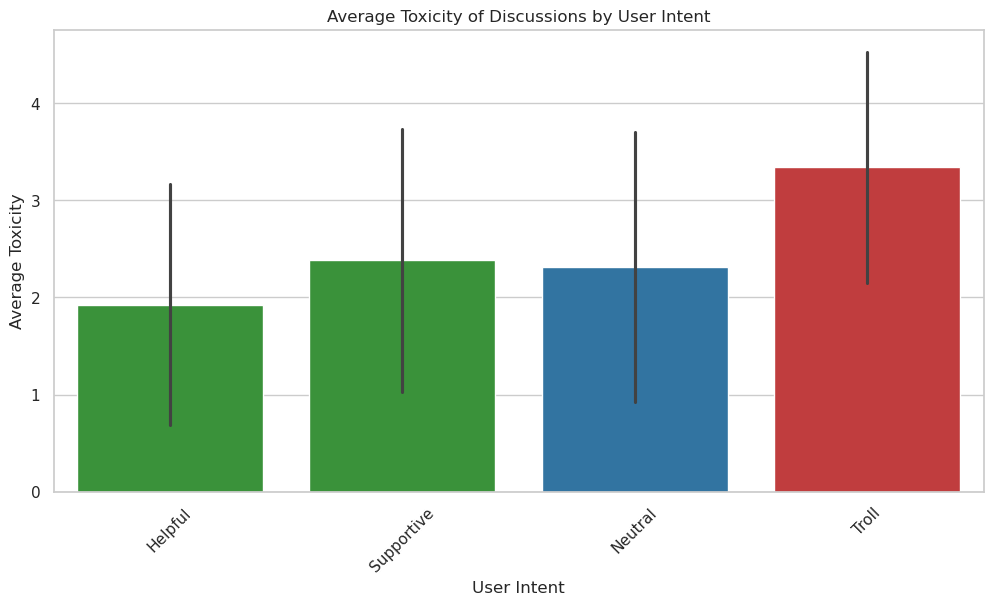

In [12]:
user_intent_order = ["Helpful", "Supportive", "Neutral", "Troll"]
palette = {"Helpful": "tab:green", "Supportive": "tab:green", "Neutral": "tab:blue", "Troll": "tab:red"}

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=combined_df,
    x="user_intent",
    hue="user_intent",
    y="toxicity",
    order=user_intent_order,
    errorbar="sd",
    palette=palette,
    legend=False,
)

# Customize the plot
plt.title("Average Toxicity of Discussions by User Intent")
plt.xlabel("User Intent")
plt.ylabel("Average Toxicity")
plt.xticks(rotation=45)
plt.show()

### Progression of toxicity

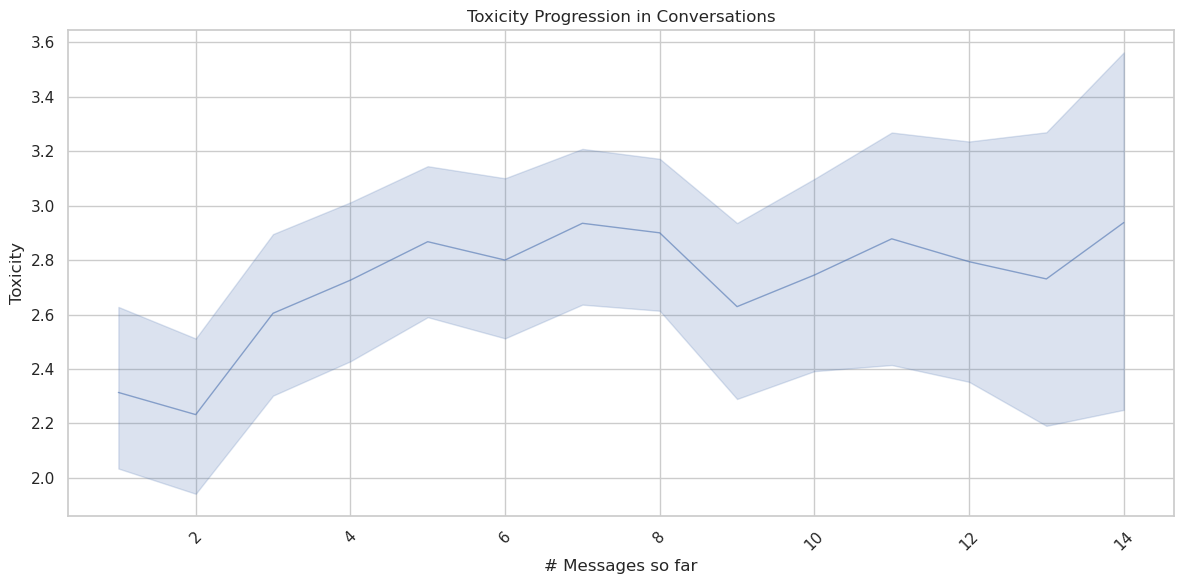

In [13]:
timeseries_df = combined_df.reset_index()
timeseries_df = timeseries_df.drop_duplicates(subset=['id', 'user', 'message'])

# remove moderator 
timeseries_df = timeseries_df[~(timeseries_df.user=="moderator")]

# Filter out conversations with fewer than X comments
conversation_counts = timeseries_df.groupby('id').size()
min_conv_len = 3 
valid_conversations = conversation_counts[conversation_counts >= min_conv_len].index
timeseries_df = timeseries_df[timeseries_df['id'].isin(valid_conversations)]

timeseries_df['message_order'] = timeseries_df.groupby('id').cumcount()
timeseries_df.message_order = timeseries_df.message_order + 1 # start from 1

plt.figure(figsize=(12, 6))
sns.lineplot(data=timeseries_df, x='message_order', y='toxicity', legend=None, lw=1, alpha=0.6)
plt.title('Toxicity Progression in Conversations')
plt.xlabel('# Messages so far')
plt.ylabel('Toxicity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

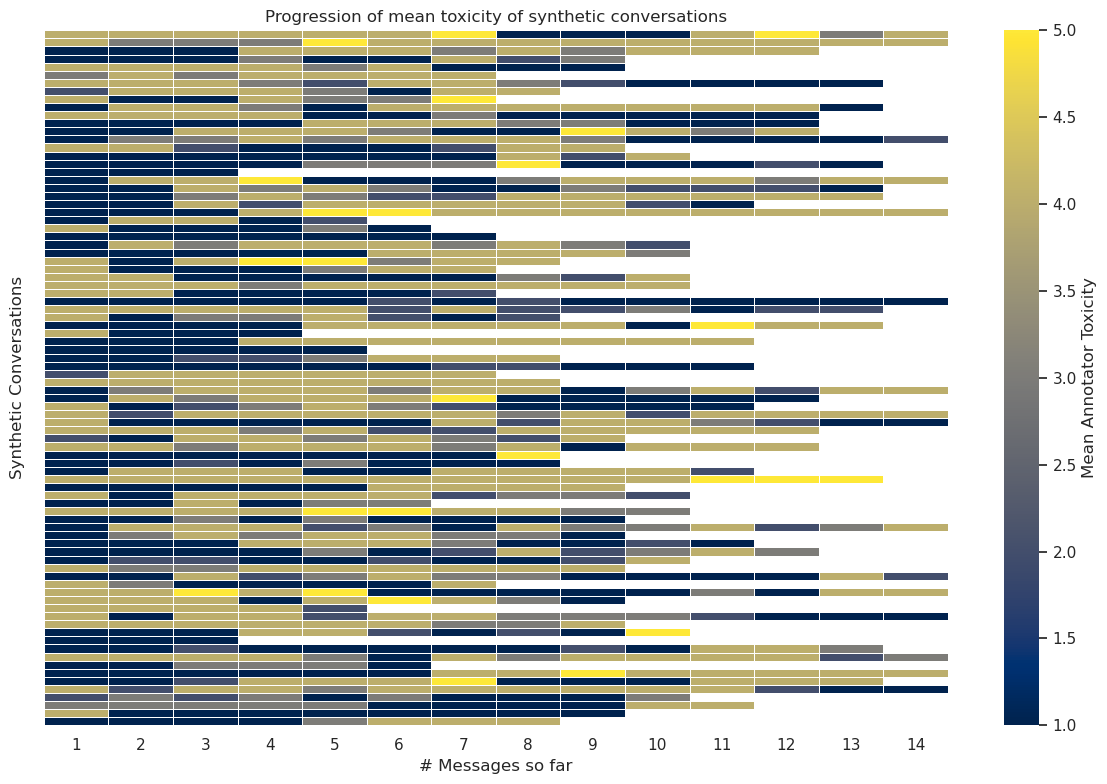

In [14]:
# Calculate the mean toxicity for each message order and conversation
mean_toxicity = timeseries_df.groupby(['id', 'message_order'])['toxicity'].mean().reset_index()

# Pivot the data to create a matrix where rows are conv_id, columns are message_order
heatmap_data = timeseries_df.pivot(index='id', columns='message_order', values='toxicity')

# Create the heatmap plot
plt.figure(figsize=(12, 8))
ax = sns.heatmap(data=heatmap_data, cmap="cividis", cbar_kws={'label': 'Mean Annotator Toxicity'}, linewidths=0.5)
ax.set(yticklabels=[])
ax.grid(False)

plt.title('Progression of mean toxicity of synthetic conversations')
plt.xlabel('# Messages so far')
plt.ylabel('Synthetic Conversations')
plt.tight_layout()
plt.show()

### Moderator impact

In [15]:
# Create two subsets: one where moderator_exists is True and one where it's False
with_moderator = timeseries_df[timeseries_df['moderator_exists'] == True]
without_moderator = timeseries_df[timeseries_df['moderator_exists'] == False]

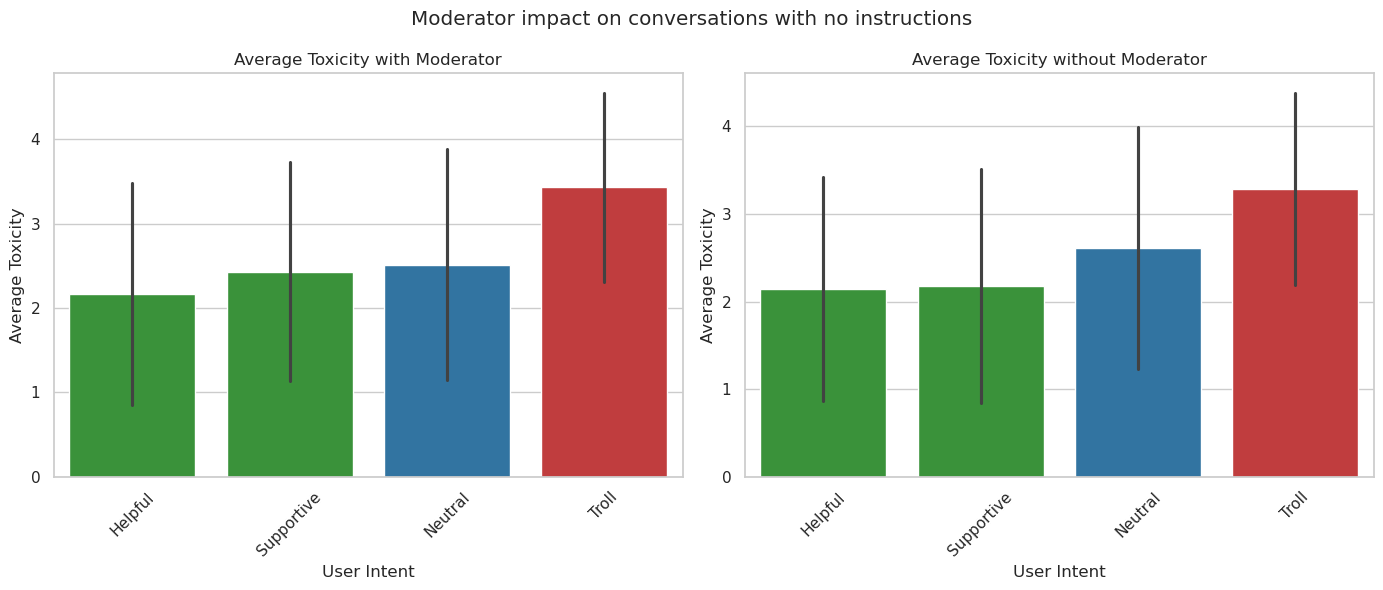

In [16]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for conversations with a moderator
sns.barplot(
    data=with_moderator,
    x="user_intent",
    hue="user_intent",
    y="toxicity",
    order=user_intent_order,
    errorbar="sd",
    palette=palette,
    ax=axes[0],  # Assign plot to first subplot (left)
    legend=False,
)
axes[0].set_title("Average Toxicity with Moderator")
axes[0].set_xlabel("User Intent")
axes[0].set_ylabel("Average Toxicity")
axes[0].tick_params(axis="x", rotation=45)

# Plot for conversations without a moderator
sns.barplot(
    data=without_moderator,
    x="user_intent",
    hue="user_intent",
    y="toxicity",
    order=user_intent_order,
    errorbar="sd",
    palette=palette,
    ax=axes[1],  # Assign plot to second subplot (right)
    legend=False,
)
axes[1].set_title("Average Toxicity without Moderator")
axes[1].set_xlabel("User Intent")
axes[1].set_ylabel("Average Toxicity")
axes[1].tick_params(axis="x", rotation=45)
fig.suptitle("Moderator impact on conversations with no instructions")

# Adjust layout for better display
plt.tight_layout()
plt.show()

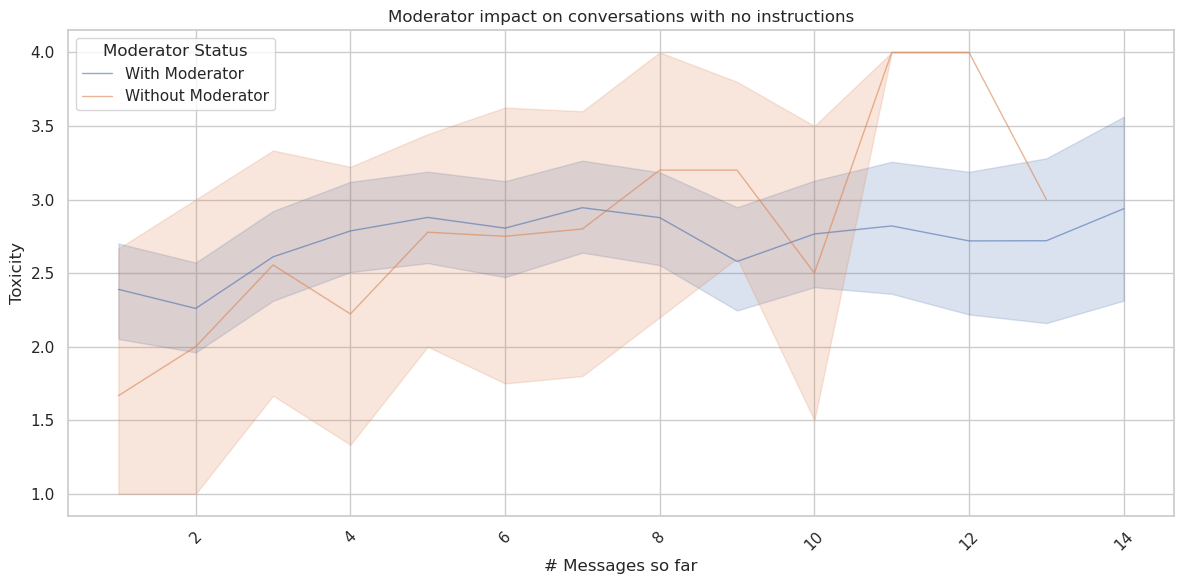

In [17]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot for conversations with a moderator
sns.lineplot(data=with_moderator, x='message_order', y='toxicity', label='With Moderator', lw=1, alpha=0.6)

# Plot for conversations without a moderator
sns.lineplot(data=without_moderator, x='message_order', y='toxicity', label='Without Moderator', lw=1, alpha=0.6)

# Customize the plot
plt.title('Moderator impact on conversations with no instructions')
plt.xlabel('# Messages so far')
plt.ylabel('Toxicity')
plt.xticks(rotation=45)
plt.legend(title='Moderator Status')
plt.tight_layout()
plt.show()